### Training Contextual Bandits through (Full) Batch Method, SGD Cls Learner, same hyperparams

In [1]:

import os
import re
import sys
import json
import time
#import config
import spotipy
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

In [2]:
import pandas as pd
import glob
import os

path = r'new data/training_set' # use your path

In [3]:
import pickle
#df_cd.to_pickle("new data/full_dataset.pkl")
full_data = pd.read_pickle("new data/full_dataset.pkl")

In [4]:
full_data = full_data.drop(columns=['session_position'])

In [5]:
full_data.head()

,session_id,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
2,62_03d8ebcd-e5e1-41a0-966b-258d296d8af7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,1,1,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
3,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
4,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   track_id                       object 
 2   context_switch                 int64  
 3   no_pause_before_play           int64  
 4   short_pause_before_play        int64  
 5   long_pause_before_play         int64  
 6   hist_user_behavior_n_seekfwd   int64  
 7   hist_user_behavior_n_seekback  int64  
 8   hist_user_behavior_is_shuffle  int32  
 9   premium                        int32  
 10  skipped                        int32  
 11  duration                       float64
 12  release_year                   int64  
 13  us_popularity_estimate         float64
 14  acousticness                   float64
 15  beat_strength                  float64
 16  bounciness                     float64
 17  danceability                   float64
 18  

In [7]:
# remove ratings of tracks with < N plays. too few plays will cause the recsys to get stuck in offline evaluation

In [8]:
def preprocess_tracks(df, min_number_of_plays=5000):
        # remove ratings of movies with < N plays
        tracks_to_keep = pd.DataFrame(df.track_id.value_counts()).loc[pd.DataFrame(df.track_id.value_counts())['track_id']>=min_number_of_plays].index
        df = df.loc[df['track_id'].isin(tracks_to_keep)]
        return df

In [9]:
data_preprocessed =  preprocess_tracks(full_data, min_number_of_plays=5000)
print(len(data_preprocessed))

1535450


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

y = np.array(data_preprocessed.skipped)
X=np.array(data_preprocessed .drop(
    columns=["skipped","session_id","track_id"], axis=1
))
print (y.shape)
#scaled_data = StandardScaler().fit_transform(X); scalling data does not improve learner's (predictive model) perfomance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.994, random_state=42, stratify=y)
print (y_train.shape)

(1535450,)
(9212,)


In [11]:
y_train.shape[0]

9212

In [12]:
# checking is classes are balanced
counts = np.unique(y_train, return_counts=True)
counts

(array([0, 1]), array([4857, 4355], dtype=int64))

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
X_train = StandardScaler().fit_transform(X_train) 

In [15]:
nchoices = y_train.shape[0]
#base_classifier = RidgeClassifier(random_state=123)

In [16]:
nchoices

9212

Batch Evaluation

In [17]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from contextualbandits.online import BootstrappedUCB, BootstrappedTS,  SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y_train.shape[0]
base_algorithm = SGDClassifier(random_state=123, loss='log', warm_start=False)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior = 'auto', percentile = 80)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior = 'auto')
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                      beta_prior = 'auto')
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = 'auto')
    #logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                              # beta_prior = beta_prior_ts, random_state = 5555) # does not work for some reason in v 0.3
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                         decay_type='threshold',
                                        beta_prior = 'auto')
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                          decay_type='percentile', decay=0.9997,
                                          beta_prior='auto')
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                                 explore_rounds=1500, beta_prior=None)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior='auto')
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                            active_choice='weighted', decay_type='percentile', decay=0.9997,
                                            beta_prior='auto')
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior='auto')
    
models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer, adaptive_active_greedy, softmax_explorer]

In [18]:
 # These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft = [list() for i in range(len(models))]
lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr,  rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft]
# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X_train[:batch_size, :]
np.random.seed(1)
y_train = np.reshape(y_train, (-1, 1))
action_chosen = np.random.randint(nchoices, size=batch_size)
print(action_chosen)

rewards_received = []
for action in action_chosen:
    rewards_received.append(int(y_train[action]))
print(rewards_received)

# fitting models for the first time, on random context X and its corresponding rewards
for model in models:
     model.fit(X=first_batch, a=action_chosen, r=np.array(rewards_received))
        
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr,lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr, lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    print(actions_this_batch)
  
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    print(new_actions_hist)
    rewards_batch = []
    for action in actions_this_batch:
        rewards_batch.append(int(y_global[action]))
    
    # keeping track of the sum of rewards received 
    rewards.append(sum(rewards_batch))
    
    # refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    print(len(X_global[:batch_end, :]))
    print(len(new_actions_hist))
    
    new_rewards_hist = []
    for action in new_actions_hist:
        new_rewards_hist.append(int(y_global[action]))
    model.fit(X_global[:batch_end, :], new_actions_hist, np.array(new_rewards_hist)) 
    
    return new_actions_hist

# running all the simulation
for i in range(int(np.floor(X_train.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_train.shape[0]])

    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                                 lst_rewards[model],
                                                 lst_actions[model],
                                                 X_train, y_train,
                                                 batch_st, batch_end)

[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
[ 97  11 215 174 230 241 235  78 120  97  95  60 180 122 183  77 190 114
  83 224 201 207  46  65  49 146 140 111  11  69 131 114 167  91  22  88
  80  51 140 179  95  87 198 183 222 254  17  22 171 120]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140

[128 134 234  63 109 184 105  38  78 170 146  74 108 138 113 242  93 112
   8  28  26  15  67  15 231  13  75 252 188  84 109 104  43 155  84  99
 184  30 199 145  95 191  56 174 248  37  94  66 167 129]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  180   52  143  111  248  187
  255  116    0  160  185  181  108  125  166  188   94  115   70  161
  251  244  132   57  126   43  238   78   27  151  155   66   13  206
  187   99  158  143   29  123  221  180  179  103  210  171  127   79
  115  160  128  134  234   63  109  184  105   38   78  170  146   74
  108  138  113  242   93  112    8   28   26   15   67   15  231   13
   75  252  188   84  109  104   43  155   84   99  184   30  199  145
   95  191   56  174  248   37   94   66  167  129]
150
150
[ 68 234  30  53 175  18 2

[ 13  55 250   9 240  98 151  84 253 173  40  47 209 235   7 232  87 187
  83 224 180 239 156  59  83  52 237 179  83 137 162  43 162  64  70  57
  50 228 160 203  41 190 217  13 130  99   5  58  87 210]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[ 38 108  93 253  15 238 143  95 174 172 151  16 241  95 148 175 190   7
  87 205 172 164   9 243  97  50 236  50  16   9 220  95   7  26 103 123
  10 236 163 126 245 238 242  11 109 172 140  59  76  58]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  246  122  240   38  157  142
  208   12  175  168  113  113  205   75   29  184  224   70  172  238
  216   60  189  233  248  178   21   76  220  239  211   82   64   11
   57  150   65  151   38  206  217   76  151  174  172  190  226  103
  114   63  117  187  165   38   78   72  228  192   79  142  147  119
   58  213   66  207   38  202   26  228    0   74  171  172   68   29
   12  131  217  115  130   72  145  252  146  238   24  238   68   69
   15   34  127  164  113   90   14  221  183  153   38  108   93  253
   15  238  143

[ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50 156
  50  50  50  50  50  50  50  50  50  50  50  50  50 234  50  50  15  50
  20  50  50  50  50 156  50  50  50  50  50  50  50  50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50

[206 114 174 143  83  43 203  29 253 224  80 172 229  50  91 214 117 225
 252 143  60 232 179  64  51 195  87 111  83 193  11 129 232   8  99 103
  57 158 110 178 126   1  23  83 116  38  93 172 107 178]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[234 234 109  15 234 109 234 234 234 234 109 234 109 234 234 234  15 234
 234 234 234 234 234 109 234 234 234 109 109 234 234 234 234 109 109 234
 234 234 234 234 234 234 234 234 234 234 234 109 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   22   15  115   15  198
   71   50  252   41  141  156  204  241  196  109  234  255   71  129
  252  196  241  216  175  234   22  233  109   20  196  216  115   50
   22  129  233  215  198   26  241  115  109  234  196  141  241  175
   22  193  196   20  241  233  198  109   15  234   15   50   22  141
  234  115   22  109  141   20  233   26   22  109  241  234  109   15
   15  218  109  241  198  175  234  109  234  234  234  109   26  141
  141   50  215  175   50  109   15  252  234   50  234  109   15   15
  109  234  234

[247  53  59  56  83  83  20 164 216 233  21 155  57 188 158  78 145 179
  79  29 111 103  30 174  86 148  83  16  11  19 124  20   0  12 216 249
 232 239 104 251  83  17 130 232  91 173  53 142 134  68]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[109 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 109 234 234 109 234 234 234 234  50 234 234 234 234 234 109 234
 234 234 234 234 234 234 234 234 234 234 234 109 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   22   15  115   15  198
   71   50  252   41  141  156  204  241  196  109  234  255   71  129
  252  196  241  216  175  234   22  233  109   20  196  216  115   50
   22  129  233  215  198   26  241  115  109  234  196  141  241  175
   22  193  196   20  241  233  198  109   15  234   15   50   22  141
  234  115   22  109  141   20  233   26   22  109  241  234  109   15
   15  218  109  241  198  175  234  109  234  234  234  109   26  141
  141   50  215  175   50  109   15  252  234   50  234  109   15   15
  109  234  234

[ 83 239 140  11 179 100 128  91  50 232  90 223  83  83 113  83 232  83
  51  11  57 111 232  51 232  91 174  11 236 224  83  11  50 221 232  91
  43 202 232  83 112  55 190  83  55 103 111  83 128 224]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[227 176 176 176 176 176  18 176 176 176 176 176 176 176  18 176  18 176
 176 176 176 176 227 176  18 127  18 176 176 176 176 176  18 176 176 176
 176 176 176 176 176 176 176 156 176 176 227 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[220 218 104 100 146 159  13  96  51  83 191 118 186 222 121 185  11  74
 132 135 130  61 185 223 205 208 129   8 184 120 230 252  87 148 161  74
  59  22 235  97 233  22 126 189 213 249 217  22  75 120]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[ 83  83  83  83  83  83  83  15  83  83 111  83  83 232 232  51  68  83
  83 232 232 155  83  91  83  83  83  83  83  83 111  83  83 232  83  83
  83 247  83  83  83 111 162  11  83  83  83  83  83  83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[ 44 136 117  37  37  37  37 136  17 216 117 133  37  84 148 117 136  37
 117 133  17  37  17  37 235  17 117  37 133 233  37  17 117  37  37  17
  37  37  17 243  27  21 133  37  17  37 117  37  37  37]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   59  205  176   77    9   52
   72   57  126  120  163  240  211   36  122   15   25   33  213    1
   17   43  106  133  172  188   95  249   52  199  106   83  123  152
  138  206   17   54  191   46  189  117  148  158   43  228  187   26
  255   75   83  196   50   41  107   90  183   73  117   87  185  102
  251  250  171  175  169  112   37  106   12  203   37   66  174  141
  186  207  178  110  214  140  102    9   63   55  195  140  153   84
  133   95  115  111  246   96  250  247   68  166   50  117   30   27
   37   34   64

[ 99  92 113  31 234  53 128 180 103 139 145   9 163 107  84 191  39 105
 190 231 208 229 245 118  52 141  31 201 240  62  91 151 140 197 229  43
  56  95 123  55  63  55 158  64  25 184 252  35 105 225]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[ 87 184 216  82 141  46 104 194 224 214 115 142  80 136  63 209 231 183
 255 119 248 165 249 152 183 187 242 227  20 193   0 231 163 245 108 168
 217 252 129 137  73 209 106  42 169  65  93 156  91  96]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  253  245  220  179  164  210
   70  251   42  231  237  136  254   83    1   22  107   48  204  253
  136  148  112  136  128   60  159   59   95  196  103   10   80  111
  100  111  233   91  220   15  220  130  213  252    8   97   18    5
   88    9  197  105  138  140   55  215  194   53  156  247  193  135
   79  161  164   90    5   36   81  242  220  169  104   55  102   49
  236  193  235    5   85   22  152  177   73    7   97  133  209  230
   35   63  230  253  187  245  198  110   87   64  132  131   22  132
  109   75   23

[176 176 176 176 176 176 176 176 176  18 176 176 176 176 176 176 176 176
 176 176 176 176 176 176  18 176 176 176 176 176 176 176 176  18  18 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[234 234 234 234 234 234 234 234 234 234 234 109 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   22   15  115   15  198
   71   50  252   41  141  156  204  241  196  109  234  255   71  129
  252  196  241  216  175  234   22  233  109   20  196  216  115   50
   22  129  233  215  198   26  241  115  109  234  196  141  241  175
   22  193  196   20  241  233  198  109   15  234   15   50   22  141
  234  115   22  109  141   20  233   26   22  109  241  234  109   15
   15  218  109  241  198  175  234  109  234  234  234  109   26  141
  141   50  215  175   50  109   15  252  234   50  234  109   15   15
  109  234  234

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  180   52  143  111  248  187
  255  116    0  160  185  181  108  125  166  188   94  115   70  161
  251  244  132   57  126   43  238   78   27  151  155   66   13  206
  187   99  158  143   29  123  221  180  179  103  210  171  127   79
  115  160  128  134  234   63  109  184  105   38   78  170  146   74
  108  138  113  242   93  112    8   28   26   15   67   15  231   13
   75  252  188   84  109  104   43  155   84   99  184   30  199  145
   95  191   56  174  248   37   94   66  167  129   56   30  239  127
   89  239  212  166  146  210   89  141   43  162   48  130  177

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[172  38 210  38 248 210  38  38  38  38  38 172  38 238  38  63 205  60
  38 172  38  50  38 172  38  38  38 172  38  38  38 172  38  38 172 163
  38  38  38  38  38 172  38  38  38 184  38 172  38  38]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  246  122  240   38  157  142
  208   12  175  168  113  113  205   75   29  184  224   70  172  238
  216   60  189  233  248  178   21   76  220  239  211   82   64   11
   57  150   65  151   38  206  217   76  151  174  172  190  226  103
  114   63  117  187  165   38   78   72  228  192   79  142  147  119
   58  213   66  207   38  202   26  228    0   74  171  172   68   29
   12  131  217  115  130   72  145  252  146  238   24  238   68   69
   15   34  127  164  113   90   14  221  183  153   38  108   93  253
   15  238  143

[179  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83
  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83
  83  83  83  83  83  83  83  83  83  83 232  83  11  83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[ 37  37  37  37  37  37  17 199 198 128  37  17  37 133  17  37 207  37
  37  37 157  37  37  37  37  37 126 135  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37  37 126  37  59  37]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   59  205  176   77    9   52
   72   57  126  120  163  240  211   36  122   15   25   33  213    1
   17   43  106  133  172  188   95  249   52  199  106   83  123  152
  138  206   17   54  191   46  189  117  148  158   43  228  187   26
  255   75   83  196   50   41  107   90  183   73  117   87  185  102
  251  250  171  175  169  112   37  106   12  203   37   66  174  141
  186  207  178  110  214  140  102    9   63   55  195  140  153   84
  133   95  115  111  246   96  250  247   68  166   50  117   30   27
   37   34   64

[139 144  14  39  22 216 113 132  80  70 106 183 102 148 180  52  54 127
 167 104 158  83  52 201 148 157  79  70  86 203  19 217 248 216 166 108
  99  52  32  38 138  12 143  75 176 109  85 199 166 136]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[ 36  59  27 232  34 245 109  32 198  32 108  48 224 137 108 124 172 156
  87 199  22  87  44 245 192 133  49 137 188 179 133 179  43 111  82  49
 245 134 177 136 233 129  58  44 216 231 253  42  58  51]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  253  245  220  179  164  210
   70  251   42  231  237  136  254   83    1   22  107   48  204  253
  136  148  112  136  128   60  159   59   95  196  103   10   80  111
  100  111  233   91  220   15  220  130  213  252    8   97   18    5
   88    9  197  105  138  140   55  215  194   53  156  247  193  135
   79  161  164   90    5   36   81  242  220  169  104   55  102   49
  236  193  235    5   85   22  152  177   73    7   97  133  209  230
   35   63  230  253  187  245  198  110   87   64  132  131   22  132
  109   75   23

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176  18 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   22   15  115   15  198
   71   50  252   41  141  156  204  241  196  109  234  255   71  129
  252  196  241  216  175  234   22  233  109   20  196  216  115   50
   22  129  233  215  198   26  241  115  109  234  196  141  241  175
   22  193  196   20  241  233  198  109   15  234   15   50   22  141
  234  115   22  109  141   20  233   26   22  109  241  234  109   15
   15  218  109  241  198  175  234  109  234  234  234  109   26  141
  141   50  215  175   50  109   15  252  234   50  234  109   15   15
  109  234  234

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  180   52  143  111  248  187
  255  116    0  160  185  181  108  125  166  188   94  115   70  161
  251  244  132   57  126   43  238   78   27  151  155   66   13  206
  187   99  158  143   29  123  221  180  179  103  210  171  127   79
  115  160  128  134  234   63  109  184  105   38   78  170  146   74
  108  138  113  242   93  112    8   28   26   15   67   15  231   13
   75  252  188   84  109  104   43  155   84   99  184   30  199  145
   95  191   56  174  248   37   94   66  167  129   56   30  239  127
   89  239  212  166  146  210   89  141   43  162   48  130  177

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[ 38  38  38 117  38  38  38  38  38  38 238  38  38  38  38  38  38  38
  38 116  38  38  38 105  38  38  38  38  38  38  38  38  38 156  38  26
  38  38  38  38  72  38  38 205  38  38  38  38  38  38]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  246  122  240   38  157  142
  208   12  175  168  113  113  205   75   29  184  224   70  172  238
  216   60  189  233  248  178   21   76  220  239  211   82   64   11
   57  150   65  151   38  206  217   76  151  174  172  190  226  103
  114   63  117  187  165   38   78   72  228  192   79  142  147  119
   58  213   66  207   38  202   26  228    0   74  171  172   68   29
   12  131  217  115  130   72  145  252  146  238   24  238   68   69
   15   34  127  164  113   90   14  221  183  153   38  108   93  253
   15  238  143

[ 83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83 232  83
  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83  83
  83  83  83  83  83  83  83  83  83  83  83  83  83  83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[181 115 219  52  16 197  78  95 220  73  42 221  16 140 234 141  79  56
 146 124  61 239 242  21 213 200 208  28  72   0 243  91 200 164 212 177
 218 125 202  62  76 119  24  82 153  65  49 229   1 155]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151   84  253  173   40   47  209  235    7  232   87

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[168 123   5 227 250  56  86 230 180  48   4  78 106 131 155  97 218 247
 216 251  78 225 154  76 162  50  81 186 228 142 126 182 204 128  23 177
 135 241 215 223 240 247 130 179  63   8 153 206 187  46]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151   84  253  173   40   47  209  235    7  232   87

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[118  15 183  88  29  76  43 180 252 202  58 193  92 147  57  62 215 129
   8 184 117  68  61 151 192 143  64 156  20 149  75  32  24 143 245 209
  93  38 254 139  42 240 202 233 145 114 249  82 137  72]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151   84  253  173   40   47  209  235    7  232   87

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[126 237 142  65 184 201 223  74 167  89 201 136 161 196  19   6 192 132
  13 140  33 150 237  94  45 102 102 139 101 255   6 229 114  65  41 157
 175 166  39  51 138 125   0 192 132 133 197 237 178 219]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   97   11  215  174  230  241
  235   78  120   97   95   60  180  122  183   77  190  114   83  224
  201  207   46   65   49  146  140  111   11   69  131  114  167   91
   22   88   80   51  140  179   95   87  198  183  222  254   17   22
  171  120  196   48   82  240   67  247  190  224  116  127   52  134
   35  142   80   26   16   92   19  135  232  216  191  138   97  122
  134   68  108  197  225   66   51   76   31  185  201  110   39  236
   96  243  216  247  204  111  211  222  249  131   13   55  250    9
  240   98  151   84  253  173   40   47  209  235    7  232   87

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  252  114  157  227  196   49
  252   62   51  115  101  125  100   41   24  233  236   66  102  232
  175    2  127   40  196    2  144  198  176  175   48  229  175   73
  113   45  249  141   40  191  129   34  176  157  196  215  254  240
  105  128   68  234   30   53  175   18  223   77  176  242  127   67
   97   57  227  122  220  121   79   25  135  112  180  232  114   38
  184   44  174  168    3  215  184  202   59   74  186   18   13  147
   77  255  216   18  132  156  147   38   54  109   29   42   73    9
   93   77  234

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   50  237  156   76  112
  196  198   20   50  241   71  216   76  156  198   26   22   22  175
  115   71  252   50  175  215  233   50  215   26  215  141  234  196
  233   76  233  234   71  233   15  249   22  129  216  234  129   22
  198  175   22  175  234   50   15  234  115   50  241  216   22   50
  196   76   50   50  249  109   50  216  156  156   50   50   20  241
  237  115   20  215  241   76  196   50  156   15   20  196   50   50
   15   50  141  196  237   26  249  252  156  241   50   50  156   50
   50   50   50   50   50   50   50   50   50   50  234   15   20

[234  89 231 105 137 168 240 203  34 255 179 224  54 234  40  31 161 169
 109 248   8 181  25 179 212 220 171 114 227  88 176 108  26  76 123   3
 129  55  83 156 180  58 117 224 126 139 203  70 251 189]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  226  100   71  252  248  143
  246  243  134   96   77  229  164  242   39    2  117   26  109   67
  184  175   58  152   62   81   74   25   88  245   30   45  220  114
   79  152   28  228  203  236  196   52  214  254   48  247  108   18
  116  181   95   25  156  158  113   30  198  113   95  145   61   98
  114    5  204  130  134   79  124   59  162  224   13  240  177   94
  148  248  192  101  201  197  117  237  252  151  233  242  162    8
  214  114  157  103  185   18  141  206   58  196  226  164  148  190
  232   72  164

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  233  198   50   22  175
  129   84  215  233   26   22  156  241   71  129   71  216  241   26
   26  196  241  215  196   22   26  252   20  196  215  115  234   22
   71  196  129   20  252  212  241  241  115   15   50  215  216  252
   36  129   20  241   20   76   22   84  109  212  115   71  129   20
   20   76   84  115  233  156  141  115  175   20  156  156   20   22
   20  216  212  234   20   50   15   20  156   20   20  252   20  109
  196   22   20  234  156  198   20  241   20   20   20   20   20   20
   20   20   20   20   20  156   20  156   20   20   20   20   20

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
1050
1050
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
1050
1050
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
1050
1050
[ 37  37  37  37  37  37  37  37  37  37  17  37  37  37  37  37  37  37
  37  37  37  37  37 107  37 146  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37  37  89  37  37  37]
[ 235 5192  905 ...   37   37   37]
1050
1050
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[129 100  73 249  30 123  21  84 253  52  75  43 206 228  51 213 203 195
 179  24 116 176  96  99 230  91 255  35 229 202  56  77 146 164 132  56
  83 114  65  25 255 185 169  78   7  23 247 212  87 180]
[ 235 5192  905 ...  212   87  180]
1200
1200
[ 38  63  38  38  38 113  38  38  38  38 139  38  38  38  38  38  98  38
  38  38  38  38  38  38  38  38  38  38  38  38 238  38  38 206  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
1200
1200
[ 20  20  20  20  20  20  20  20 156  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20 156  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
1200
1200
[186 223 112 194  89 234 213  42   7 189 160 232 135 161 209  17  15  58
   0 245 152 245 112 197 215 112 104 137 137 149 109   0 245 182  21 195
  17  69 156 242  84 112 212 180 103 212 152 236 202 161]
[ 235 5192  905 ...  236  202  161]
1200
1200


[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
1400
1400
[ 37  37  37 100  37  37  37  37  37  37  37  37  37  37  37 131  37  19
  37  37  37  28  37  37  37  37  37  37  37  37 121  37  37  37  27 202
  37  37  37  37  37  37  37  37  37  37  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
1400
1400
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
1400
1400
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
1400
1400
[ 33 166 228 224 111  18 185 202  59  13 166 165 2

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
1550
1550
[104  15 112 156  27 209  58 136  83 210 188 124  15 245 109  91 136 209
 156 219 141  49 135  13  34 103  30  43 210  49  15 245 137 156 149 149
   7 245  84 209 209  84 153  17 137  13 136 136  53  17]
[ 235 5192  905 ...  136   53   17]
1550
1550
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
1600
1600
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
1600
1600
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176

[234 234 234 234 234 184 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
1750
1750
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
1750
1750
[ 38  38  38  38 210  38  38  38  38  38  38 123  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38 160  38  38  38  38  38  38 141  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
1750
1750
[ 20  20  20  20  20  20  20  20  20  20  20 156  20  20  20  20  20  20
  20  20  26  20  50  50  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
1750
1750
[ 91  50 245  15 111 254  91 245  17 245  73 242 149  13  17  11 186 209
 245  84 111  15 152  83 120

[ 37  37  37  37  37  37  37  37  37  37  72  37 182 128  37  37  37  37
  37  37 245  37  37  37  37  37  37  37  37  37  62  37  37  37   2  37
  23  37  37 157  37  37  37 149  37  37  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
1950
1950
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
1950
1950
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
1950
1950
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
1950
1950
[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38 

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
2150
2150
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
2150
2150
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
2150
2150
[ 37  37  37  37  37  37  37  37  55  37 192  37  37  37  37  37  37  37
  37  37 167  37  37  37  44 198  37  37  37  37  37  37  37  37  37  89
  37  37  37  37  37 193  37 143 171 150  37  37  37  34]
[ 235 5192  905 ...   37   37   34]
2150
2150
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20 241  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2300
2300
[212  91 112 245 245 245 212 156 245 156 152 245 149 245 245 245 245 245
  91 245  91  17 209 245 245  15 245 245 209 245 245 245 245  15 245 245
 245 141 245 156 245  72 112 245  83 245 245 245 136 245]
[ 235 5192  905 ...  245  136  245]
2300
2300
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
2350
2350
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
2350
2350
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 17

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 254 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
2500
2500
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2500
2500
[38 24 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 60 38 38 38 38 38 38 38 38 38 38 98 38 38 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
2500
2500
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
2500
2500
[245 245 245 156 245 245 137 245 245  91  15 245 245 245 245 156 245 209
 245 245 245 245  17  84 245 245 245 245 245 209  91 245 245 137 245 245
 245 245 245 245 137 245 245 245 245 245 245 245 245 24

[ 37  37  37  37  37  37  37 101  37  37 175  87  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  13  37  37  37  37  37  37  88]
[ 235 5192  905 ...   37   37   88]
2700
2700
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
2700
2700
[234 234 234 234 234 198 234 234 234 181 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
2700
2700
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2700
2700
[ 38  38  38  38  38  38  38  38  38  38  38 195  38  38  38 151  38   7
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
 117 

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
2900
2900
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
2900
2900
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
2900
2900
[ 37  37  37  37  37  37 217  37 179  37  37  37  37  37  37  37  37  37
  37  37 106  37  37  37  37  37  37  37 181  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37 215  37  20  37  37  37]
[ 235 5192  905 ...   37   37   37]
2900
2900
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[ 38  38  38  38  60  38  38  38  38  38  38  38  38  38  38  38  38  38
 238  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
3050
3050
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20 156  20  20  20  84]
[ 235 5192  905 ...   20   20   84]
3050
3050
[245 245 124 245 245 245 245 245 245 245 245 245 209 245 245 245 245 245
 245  17 245 245 245 245 245 209 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
3050
3050
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
3100
3100
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 1

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
3250
3250
[234 234 234 234 234 234 234 234 234 234   7 234 234 234   0 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234  86 234 234]
[ 235 5192  905 ...   86  234  234]
3250
3250
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3250
3250
[ 38  38  38  38  38  38  38 145  38  38 238  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38 116  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
3250
3250
[20 20 20 20 20 20 20 20 15 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 50 20 20 20 20 20 20 84 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 2

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
3450
3450
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
3450
3450
[162 192 222  37  37  37  37  37  37  37 198  37  37  37  37 193  37  37
  37  37  37  37  37  21  37  37  37  37  37  37  37  37  87  88  37  37
  37  37  37 226  37  37  37 104  37  37  37  37  37  76]
[ 235 5192  905 ...   37   37   76]
3450
3450
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
3450
3450
[234 234 234 234 234 234 234 234 234 234  53 234 234 234 234 234 234 168
 234 167 234 234 234 234 23

[ 20  20 234  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  50  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
3600
3600
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
3600
3600
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
3650
3650
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
3650
3650
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 17

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 140 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
3800
3800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3800
3800
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
3800
3800
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20 156  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
3800
3800
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
4000
4000
[ 37  37  37  37  37  37 149  37  37  37  37  37  37  37 212  37  37  37
  37  37  37  37  37  37  37  37 107  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37 210  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
4000
4000
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
4000
4000
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 117 234 234 234 234 101 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
4000
4000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
4150
4150
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
4200
4200
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4200
4200
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
4200
4200
[ 37  37  37  37  37  37  37  37  37  37  37  37  37 189  37  37  37  37
 161 102  37  37  37  37  3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4350
4350
[ 38  38  38  38  38  38  38 155  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  76  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
4350
4350
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  50  20  20  20  20  20  20 156  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
4350
4350
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 156 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
4350
4350
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
4550
4550
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234  90 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
4550
4550
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4550
4550
[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38 145  38  38  38  38  38  38  38  38  38  38  38 239  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
4550
4550
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 84 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 2

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
4750
4750
[ 37  76 134  79  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  28  23  37  37  37  37  37  37  37  37  37  37  37  37  96  37  37  37
 214  37  37  37  37  37  37  37  37 111 120  37  37  37]
[ 235 5192  905 ...   37   37   37]
4750
4750
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
4750
4750
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234  22 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234  60 234 234 215 234]
[ 235 5192  905 ...  234  215  234]
4750
4750
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
4900
4900
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
4950
4950
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4950
4950
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
4950
4950
[ 37  37  18  37  37  37 219  37  37  81  37  37  37  37  37 220  37  37
  37  37  37  37  37  37  3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5100
5100
[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38 238
  38  38  38  38  38  38  15  38  38  38  38  38  38 159]
[ 235 5192  905 ...   38   38  159]
5100
5100
[ 20  20 212  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20 212  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  84  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
5100
5100
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
5100
5100
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 

[ 37  37  37  37  37 124  88  37  37  37   2  37  37 159  37  37  37 197
 160  37  37  37  37  37  37  37  37  37  37 191 243  37  37  37 250 115
 186  37  37  37  37  37  37  37  37 239 205  37  37 122]
[ 235 5192  905 ...   37   37  122]
5300
5300
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
5300
5300
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
5300
5300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5300
5300
[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38 217  38  38  38  38 205  38  38  38  38  38  38  38
  38 

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
5500
5500
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
5500
5500
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
5500
5500
[ 37  37  37  37  37  37  37  37  37  37  37  37  37  37  37 197  37  37
  37  37  37  37  37  96  37 169  37  37  37  37  37  37  37  37  37 104
  37  37  37  37  37  47  37 136  37  37  37  37 155  37]
[ 235 5192  905 ...   37  155   37]
5500
5500
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38   7  38  38  38  38  38  38  38  38  38 116  38  38]
[ 235 5192  905 ...  116   38   38]
5650
5650
[ 20  20  20  20  20  20  20  20  20  20  15  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  84  20
  20  20  20  20  20  20  20  20  20  20  20  20  20 156]
[ 235 5192  905 ...   20   20  156]
5650
5650
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
5650
5650
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
5700
5700
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 1

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
5850
5850
[234 234 234 234 234 234 234 234 234 170 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
5850
5850
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5850
5850
[ 38  38  38  38  38  38  38  38 243  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
5850
5850
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 2

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
6050
6050
[ 37  37 157  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37 105  37  37  37 219  37  37  37  37  37  37  37
  45  37  37  37  37  57  37  37  37  37  37 121  37  37]
[ 235 5192  905 ...  121   37   37]
6050
6050
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
6050
6050
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234  32 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
6050
6050
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
6200
6200
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
6250
6250
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
6250
6250
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
6250
6250
[ 37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  84
  37  37  37  37  37  37  3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6400
6400
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
6400
6400
[ 20  20  20  20  20  20  20  20  20  20 212  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
6400
6400
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
6400
6400
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 8

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
6600
6600
[234 234 111 234 234 234 234 234 234 234 234  52 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234  83 234 194 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234  64]
[ 235 5192  905 ...  234  234   64]
6600
6600
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6600
6600
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
6600
6600
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20 212  20  20  20  20  20  20  2

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
6800
6800
[ 37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37 189  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37  37 165  37  37  37  37  37  37  37  37  37 191  37]
[ 235 5192  905 ...   37  191   37]
6800
6800
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
6800
6800
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
6800
6800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
7000
7000
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7000
7000
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
7000
7000
[ 37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
 170  37  94 241  37  37  37  37  37  37  37  76  37  37  37 147  37  37
  37  37  37  37  37 158  37  23  37  37  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
7000
7000
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20 129  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20 109  20  20]
[ 235 5192  905 ...  109   20   20]
7150
7150
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
7150
7150
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
7200
7200
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7200
7200
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 17

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234  97 234 234 234 234 234 234 234 234 234
 234 245 234 234   6 234 234 234 234 234 234 125 234 234]
[ 235 5192  905 ...  125  234  234]
7350
7350
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7350
7350
[ 38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38 113  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
7350
7350
[ 20 156  20  20  20  20  20  20 234  20  20  20  20  20  20  20  20  20
  20  20  20 212  20  20  20  84  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20 156  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7350
7350
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245

[ 37 214  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
 172  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  46  37  37  37  37  37  37  37  37 232  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
7550
7550
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
7550
7550
[234 234 234 234 234 234 234 234 234 234 234 234 234 118 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
7550
7550
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7550
7550
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 3

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7750
7750
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
7750
7750
[ 37  37  37  37  37  37  37  37  37 208  37  37  37  37  71  37  37  37
  37  37  37  37  37 111  37  37  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  21  37  37  37  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
7750
7750
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
7750
7750
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 222 234 234 234
 234 234 234 234 234 234 23

[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
7900
7900
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
7950
7950
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7950
7950
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
7950
7950
[109  37  37 233 237  37  37  37  37  37  37  37  37  37  37  37 111  37
  37  37  37  37  37  37  3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8100
8100
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 50 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
8100
8100
[109  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
8100
8100
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
8100
8100
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 8

[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
8300
8300
[234 234 234  41 234  22 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
8300
8300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8300
8300
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 11 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38]
[ 235 5192  905 ...   38   38   38]
8300
8300
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 15 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
8300
8300
[

[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
8500
8500
[ 37  37  37  37  37  37  37  37  37 135  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  37  37 133  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  37  37]
[ 235 5192  905 ...   37   37   37]
8500
8500
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50]
[ 235 5192  905 ...   50   50   50]
8500
8500
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
8500
8500
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
8700
8700
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
8700
8700
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176]
[ 235 5192  905 ...  176  176  176]
8700
8700
[ 37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37 188  37  37  37  37  37  37  37  80  37  37
  37  37  37  37  37  37  37  37  37  37   8  37  37  37]
[ 235 5192  905 ...   37   37   37]
8700
8700
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
8850
8850
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
8850
8850
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83]
[ 235 5192  905 ...   83   83   83]
8900
8900
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
8900
8900
[176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176 176
 176

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
9050
9050
[ 38  38 194  38  38  38  38  38  38 210  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38  38
  38  38  38  38  38  38  38  38  38  38  38  38  38  38]
[ 235 5192  905 ...   38   38   38]
9050
9050
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20 212]
[ 235 5192  905 ...   20   20  212]
9050
9050
[245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
9050
9050
[83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 

[245 245 245 245 245 245 245 245 245 245 245 245]
[ 235 5192  905 ...  245  245  245]
9212
9212


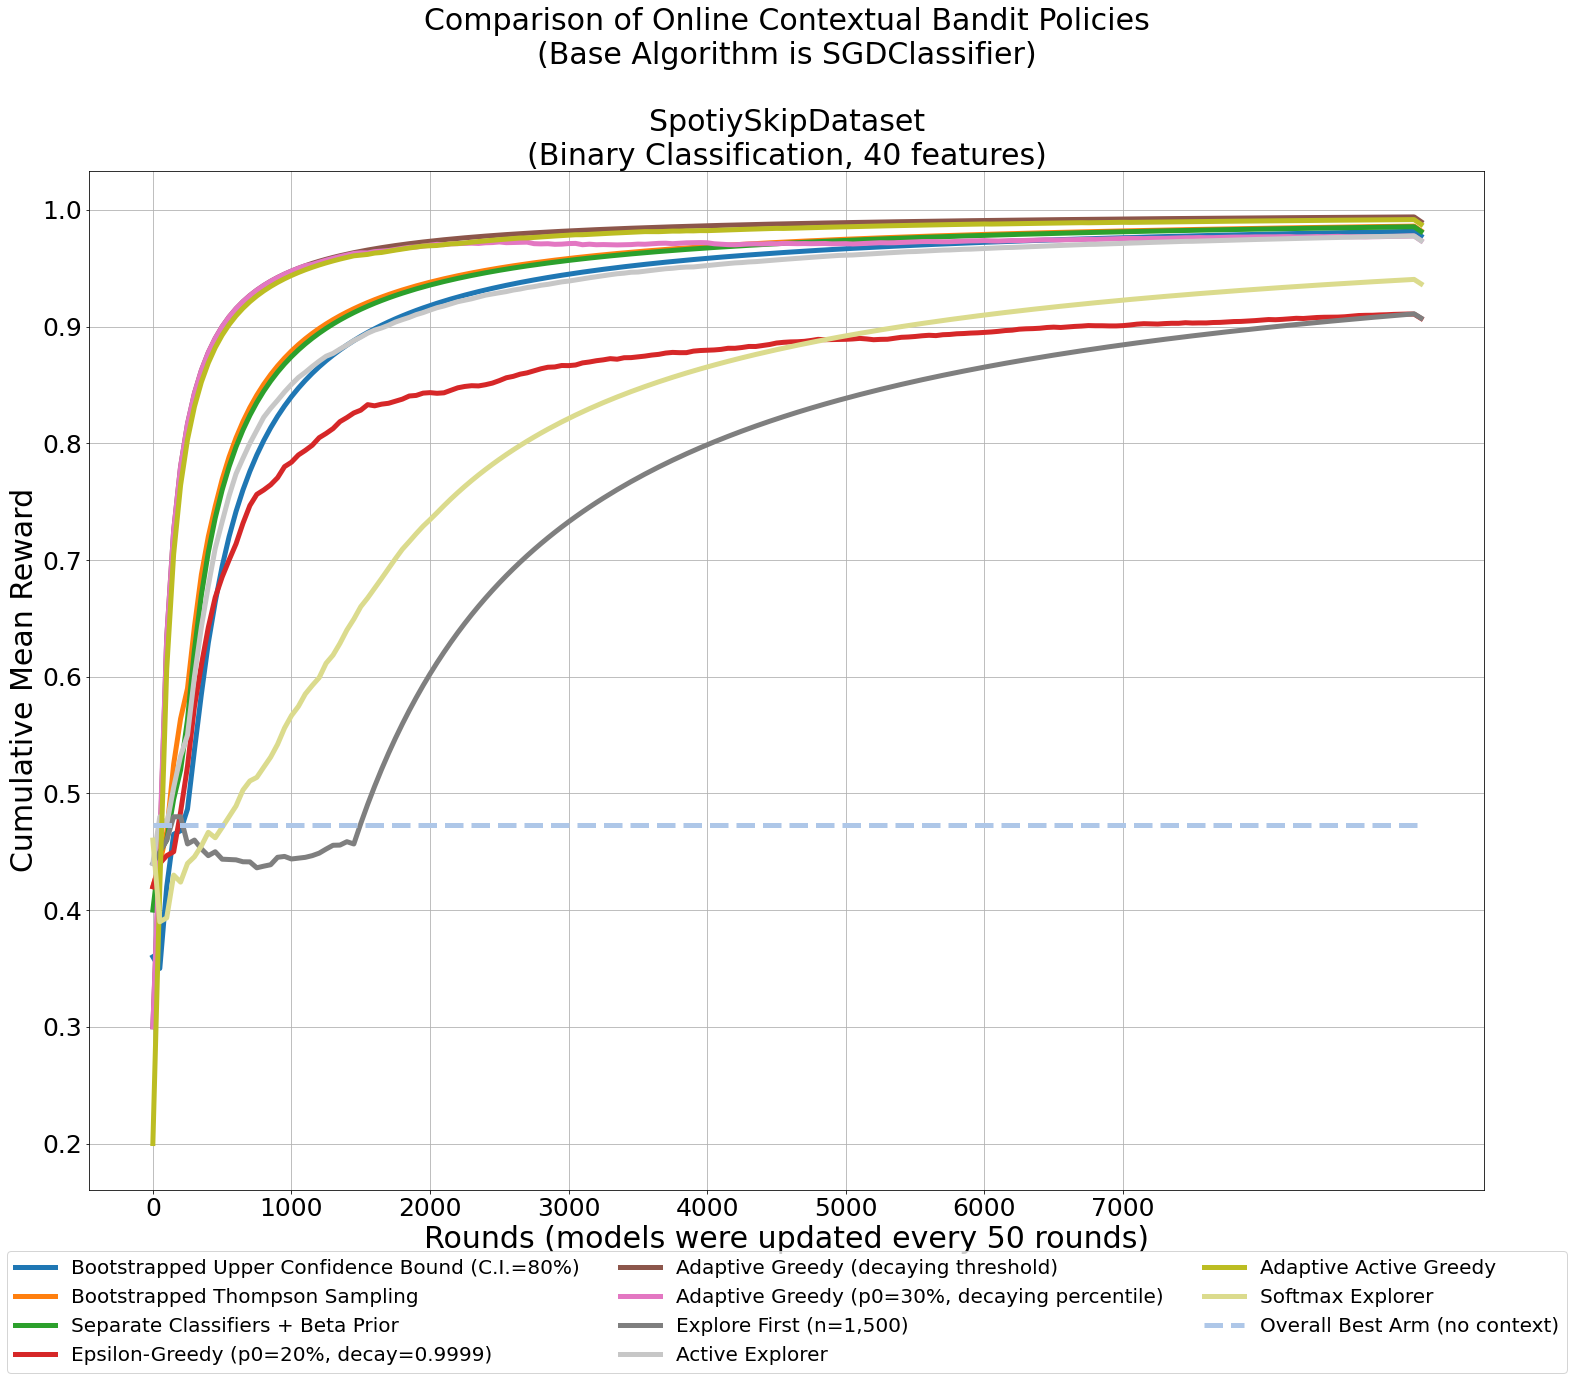

In [19]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
        mean_rew=list()
        for r in range(len(reward_lst)):
            mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
        return mean_rew
rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
#plt.plot(get_mean_reward(rewards_lucb), label=\"Logistic Upper Confidence Bound (C.I.=70%)\",linewidth=lwd,color=colors[8])\n",
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

# import warnings\n",
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is SGDClassifier)\n\nSpotiySkipDataset\n(Binary Classification, 40 features)',size=30)
plt.grid()
plt.show()